# BGE distillation

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
import pandas as pd
from itertools import combinations

In [7]:
df_train = pd.read_csv('Train.csv')  # or however you load
df_val = pd.read_csv('Valid.csv')

In [8]:
# train corpus
corpus = df_train['text'].sample(60).to_list()
corpus_val = df_val['text'].sample(20).to_list()

In [10]:
# ----- Configuration -----
teacher_model_name = "BAAI/bge-small-en"
student_model_name = "distilbert-base-uncased"
save_path = "student_model.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Datasets -----
class TextPairDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# Assuming corpus and corpus_val are defined lists of sentences.
# Example:
# corpus = ["sentence1", "sentence2", ...]
# corpus_val = ["val_sentence1", "val_sentence2", ...]

# Generate all pairwise combinations for training and validation
train_pairs = list(combinations(corpus, 2))
val_pairs = list(combinations(corpus_val, 2))

train_dataset = TextPairDataset(train_pairs)
val_dataset = TextPairDataset(val_pairs)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# ----- Models -----
class EmbeddingModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.pool = lambda x: x.last_hidden_state[:, 0]  # [CLS] pooling

    def forward(self, input_ids, attention_mask, **kwargs):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = self.pool(output)
        return F.normalize(embeddings, p=2, dim=1)

# Load teacher (frozen)
teacher = EmbeddingModel(teacher_model_name).to(device)
teacher.eval()

# Load student (trainable)
student = EmbeddingModel(student_model_name).to(device)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(student_model_name)

# ----- Distance Loss -----
class ScaledDistanceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = nn.Parameter(torch.tensor(1.0))

    def forward(self, emb_s_1, emb_s_2, dist_t):
        dist_s = F.cosine_similarity(emb_s_1, emb_s_2)
        loss = F.mse_loss(dist_s, self.alpha * dist_t)
        return loss

# ----- Training Setup -----
optimizer = torch.optim.Adam(student.parameters(), lr=2e-5)
loss_fn = ScaledDistanceLoss().to(device)
num_epochs = 5

best_val_loss = float('inf')
patience = 3
early_stop_counter = 0

# ----- Training Loop with Early Stopping -----
for epoch in range(num_epochs):
    student.train()
    epoch_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        texts1, texts2 = batch  # batch is a tuple: (list_of_texts1, list_of_texts2)

        # Tokenize training pairs
        inputs1 = tokenizer(list(texts1), return_tensors='pt', padding=True, truncation=True).to(device)
        inputs2 = tokenizer(list(texts2), return_tensors='pt', padding=True, truncation=True).to(device)

        # Teacher distances (no grad)
        with torch.no_grad():
            emb_t_1 = teacher(**inputs1)
            emb_t_2 = teacher(**inputs2)
            dist_t = F.cosine_similarity(emb_t_1, emb_t_2)

        # Student embeddings
        emb_s_1 = student(**inputs1)
        emb_s_2 = student(**inputs2)

        # Loss
        loss = loss_fn(emb_s_1, emb_s_2, dist_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - alpha: {loss_fn.alpha.item():.4f}")

    # ----- Validation -----
    student.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            texts1, texts2 = batch

            # Tokenize validation pairs
            inputs1 = tokenizer(list(texts1), return_tensors='pt', padding=True, truncation=True).to(device)
            inputs2 = tokenizer(list(texts2), return_tensors='pt', padding=True, truncation=True).to(device)

            # Teacher distances
            emb_t_1 = teacher(**inputs1)
            emb_t_2 = teacher(**inputs2)
            dist_t = F.cosine_similarity(emb_t_1, emb_t_2)

            # Student embeddings
            emb_s_1 = student(**inputs1)
            emb_s_2 = student(**inputs2)

            loss = loss_fn(emb_s_1, emb_s_2, dist_t)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")

    # ----- Early Stopping Check -----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        # Optionally, save the best model here:
        torch.save({
            'model_state_dict': student.state_dict(),
            'scaling_alpha': loss_fn.alpha.item()
        }, save_path)
        print("Best model updated and saved.")
    else:
        early_stop_counter += 1
        print(f"No improvement. Early stopping counter: {early_stop_counter}/{patience}")
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

print(f"\nTraining complete. Best Validation Loss: {best_val_loss:.4f}")


Training Epoch 1: 100%|███████████████████████████████████████████████████████████████| 222/222 [01:53<00:00,  1.96it/s]


Epoch 1/5 - Train Loss: 0.0006 - alpha: 1.0000


Validation Epoch 1: 100%|███████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.24it/s]


Epoch 1 - Validation Loss: 0.0009
Best model updated and saved.


Training Epoch 2: 100%|███████████████████████████████████████████████████████████████| 222/222 [01:53<00:00,  1.95it/s]


Epoch 2/5 - Train Loss: 0.0002 - alpha: 1.0000


Validation Epoch 2: 100%|███████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.24it/s]


Epoch 2 - Validation Loss: 0.0011
No improvement. Early stopping counter: 1/3


Training Epoch 3: 100%|███████████████████████████████████████████████████████████████| 222/222 [01:54<00:00,  1.94it/s]


Epoch 3/5 - Train Loss: 0.0002 - alpha: 1.0000


Validation Epoch 3: 100%|███████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.22it/s]


Epoch 3 - Validation Loss: 0.0012
No improvement. Early stopping counter: 2/3


Training Epoch 4: 100%|███████████████████████████████████████████████████████████████| 222/222 [01:53<00:00,  1.95it/s]


Epoch 4/5 - Train Loss: 0.0001 - alpha: 1.0000


Validation Epoch 4: 100%|███████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.23it/s]

Epoch 4 - Validation Loss: 0.0019
No improvement. Early stopping counter: 3/3
Early stopping triggered.

Training complete. Best Validation Loss: 0.0009


In [11]:
# ----- Path and device -----
save_path = "student_model.pt"
model_name = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Define same model class -----
class EmbeddingModel(torch.nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.pool = lambda x: x.last_hidden_state[:, 0]  # [CLS] pooling

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = self.pool(output)
        return F.normalize(embeddings, p=2, dim=1)




In [12]:
def get_embeddings_batched(texts, model, tokenizer, device, batch_size=16):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        # Check if outputs has 'last_hidden_state'
        if hasattr(outputs, "last_hidden_state"):
            embeddings = outputs.last_hidden_state[:, 0, :]
        else:
            embeddings = outputs  # already the embedding tensor
        all_embeddings.append(embeddings.cpu())
    return torch.cat(all_embeddings, dim=0)

In [15]:
import torch, gc
torch.cuda.empty_cache()
gc.collect()

501

In [16]:
df_test = df_val.sample(200)
review = df_test['text'].to_list()
labels = df_test['label'].to_numpy()

# For the student model
model = EmbeddingModel(model_name).to(device)
checkpoint = torch.load(save_path, map_location="cpu")
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)  # move model to GPU after loading weights on CPU
model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)
embedding_1 = get_embeddings_batched(review, model, tokenizer, device, batch_size=16)
del model
torch.cuda.empty_cache()

# For the original model (DistilBERT)
model_original = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
model_original.eval()
# You can reuse the same tokenizer if appropriate
embedding_2 = get_embeddings_batched(review, model_original, tokenizer, device, batch_size=16)
del model_original
torch.cuda.empty_cache()

# For the BGE model
bge_model_name = "BAAI/bge-small-en"
model_bge = AutoModel.from_pretrained(bge_model_name).to(device)
tokenizer_bge = AutoTokenizer.from_pretrained(bge_model_name)
model_bge.eval()
embedding_3 = get_embeddings_batched(review, model_bge, tokenizer_bge, device, batch_size=16)
del model_bge
torch.cuda.empty_cache()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


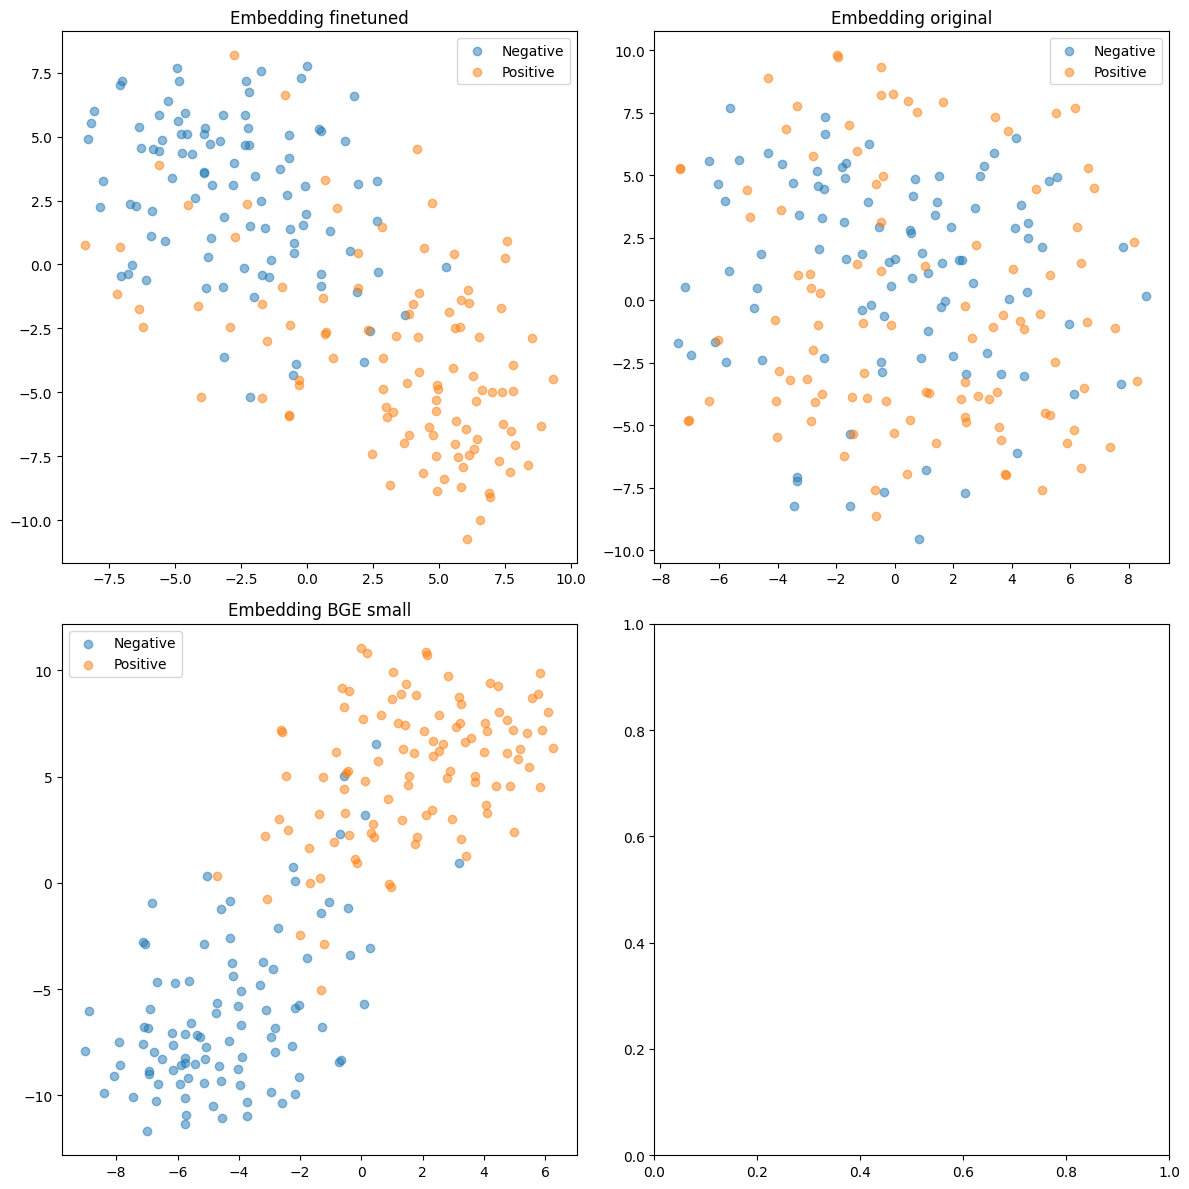

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

names=['finetuned', 'original', 'BGE small']
# Function to perform t-SNE and plot
def tsne_plot(embeddings, labels):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    for i, embedding in enumerate(embeddings):
        # Perform t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(embedding)

        # Plot
        ax = axs[i//2, i%2]
        ax.scatter(tsne_results[labels == 0, 0], tsne_results[labels == 0, 1], label='Negative', alpha=0.5)
        ax.scatter(tsne_results[labels == 1, 0], tsne_results[labels == 1, 1], label='Positive', alpha=0.5)
        ax.set_title(f'Embedding {names[i]}')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Perform t-SNE and plot for all embeddings
tsne_plot([embedding_1, embedding_2, embedding_3], labels)